# Example of fitting: 51 Pegasi b

To show how to fit some RV data, let's start with possibly the most famous exoplanet, 51 Peg b. We will quickly fit a circular model, find a best-fit solution using MAP, explore parameter uncertainty with MAP, and derive a mass-estimate $M_p\sin{i}$.

The ELODIE data and parameters used in this example notebook for 51 Peg b were obtained from [Birkby et al. 2017](http://doi.org/10.3847/1538-3881/aa5c87).

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import knuth_bin_width

import ravest.prior
from ravest.fit import Fitter
from ravest.model import calculate_mpsini
from ravest.param import Parameter, Parameterisation

In [ ]:
fpath = Path.cwd() / "example_data" / "51Pegb.txt"
data = pd.read_csv(fpath, delimiter='\s+')
# Convert to BTJD (Barycentric TESS Julian Date) by subtracting 2457000
data["time"] = data["time"] - 2457000
data

,time,vel,verr,tel
0,-7389.467245,-33258.0,9.0,ELODIE
1,-7387.528344,-33225.0,9.0,ELODIE
2,-7344.688737,-33272.0,7.0,ELODIE
3,-7271.772638,-33310.0,7.0,ELODIE
4,-7270.775020,-33248.0,7.0,ELODIE
...,...,...,...,...
148,-4387.643306,-33266.0,8.0,ELODIE
149,-4166.392013,-33315.0,7.0,ELODIE
150,-4147.379446,-33196.0,7.0,ELODIE
151,-4141.412989,-33300.0,8.0,ELODIE


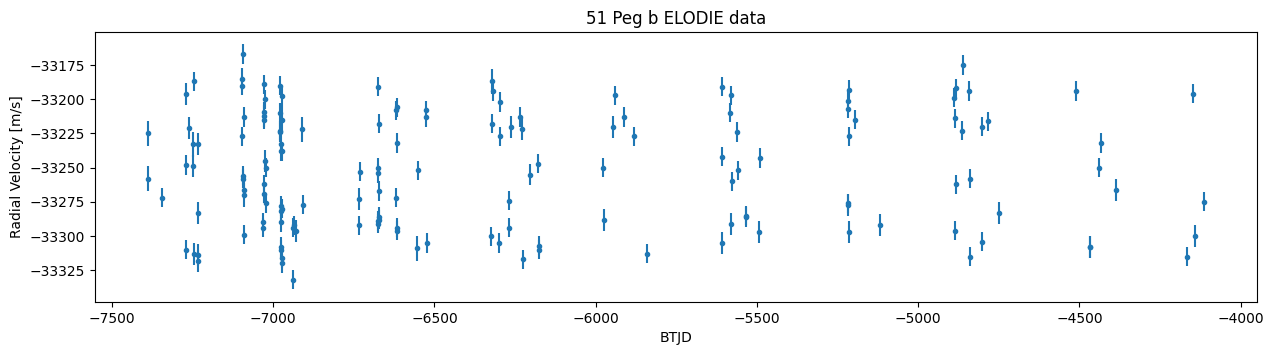

In [ ]:
plt.figure(figsize=(15,3.5))
plt.title("51 Peg b ELODIE data")
plt.ylabel("Radial Velocity [m/s]")
plt.xlabel("BTJD")
plt.errorbar(data["time"], data["vel"], yerr=data["verr"], marker=".", linestyle="None")
plt.show()

In [ ]:
fitter = Fitter(planet_letters=["b"], parameterisation=Parameterisation("P K e w Tc"))
fitter.add_data(time=data["time"].to_numpy(), 
                vel=data["vel"].to_numpy(), 
                verr=data["verr"].to_numpy(), 
                t0=np.mean(data["time"]))
print("t0:", fitter.t0)

# Construct the params dict
# These values will be used as your initial guess for the MAP fit
params_dict = {
          "P_b": Parameter(4.23, "d", fixed=False),
          "K_b": Parameter(60, "m/s", fixed=False),
          "e_b": Parameter(0, "", fixed=True),
          "w_b": Parameter(np.pi/2, "rad", fixed=True),
          "Tc_b": Parameter(2456325.94 - 2457000, "d", fixed=False),  # Convert to BTJD

          "g": Parameter(np.median(fitter.vel), "m/s", fixed=False),
          "gd": Parameter(0, "m/s/day", fixed=True),
          "gdd": Parameter(0, "m/s/day^2", fixed=True),
          "jit": Parameter(0, "m/s", fixed=True),}

fitter.params = params_dict
fitter.params

t0: -6243.54519806536


{'P_b': Parameter(value=4.23, unit='d', fixed=False),
 'K_b': Parameter(value=60, unit='m/s', fixed=False),
 'e_b': Parameter(value=0, unit='', fixed=True),
 'w_b': Parameter(value=1.5707963267948966, unit='rad', fixed=True),
 'Tc_b': Parameter(value=-674.0600000000559, unit='d', fixed=False),
 'g': Parameter(value=-33252.0, unit='m/s', fixed=False),
 'gd': Parameter(value=0, unit='m/s/day', fixed=True),
 'gdd': Parameter(value=0, unit='m/s/day^2', fixed=True),
 'jit': Parameter(value=0, unit='m/s', fixed=True)}

Next, we need to add prior functions for the free parameters. Ravest has a range of prior functions available:

In [ ]:
ravest.prior.PRIOR_FUNCTIONS

['Uniform',
 'EccentricityUniform',
 'Normal',
 'TruncatedNormal',
 'HalfNormal',
 'Rayleigh',
 'VanEylen19Mixture',
 'Beta']

In [ ]:
# Construct the priors dict. Every parameter that isn't fixed requires a prior.
priors_dict = {
          "P_b": ravest.prior.Normal(params_dict["P_b"].value, 0.000001),
          "K_b": ravest.prior.Uniform(lower=0, upper=100),
          "Tc_b": ravest.prior.Uniform(lower=params_dict["Tc_b"].value-2.0, upper=params_dict["Tc_b"].value+2.0),
          "g": ravest.prior.Uniform(lower=params_dict["g"].value-np.std(fitter.vel), upper=params_dict["g"].value+np.std(fitter.vel)),
        }

fitter.priors = priors_dict
fitter.priors

{'P_b': Normal(mean=4.23, std=1e-06),
 'K_b': Uniform(lower=0, upper=100),
 'Tc_b': Uniform(lower=-676.0600000000559, upper=-672.0600000000559),
 'g': Uniform(lower=-33293.6610064078, upper=-33210.3389935922)}

Now that we have loaded the `Fitter` with the data, our parameterisation, our initial parameter values, and priors for each of the free parameters, we can now fit the free parameters of the model to the data. First, Maximum A Posteriori (MAP) optimisation is performed to find the best-fit solution that maximises the log-probability (log likelihood + log priors).

In [ ]:
map_result = fitter.find_map_estimate(method="Powell")
map_result

MAP parameter results: {'P_b': 4.230000383665882, 'K_b': 55.7090506156201, 'Tc_b': -674.1092511099605, 'g': -33251.24252246648}


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 794.8026450933176
       x: [ 4.230e+00  5.571e+01 -6.741e+02 -3.325e+04]
     nit: 3
   direc: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
           [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
    nfev: 127

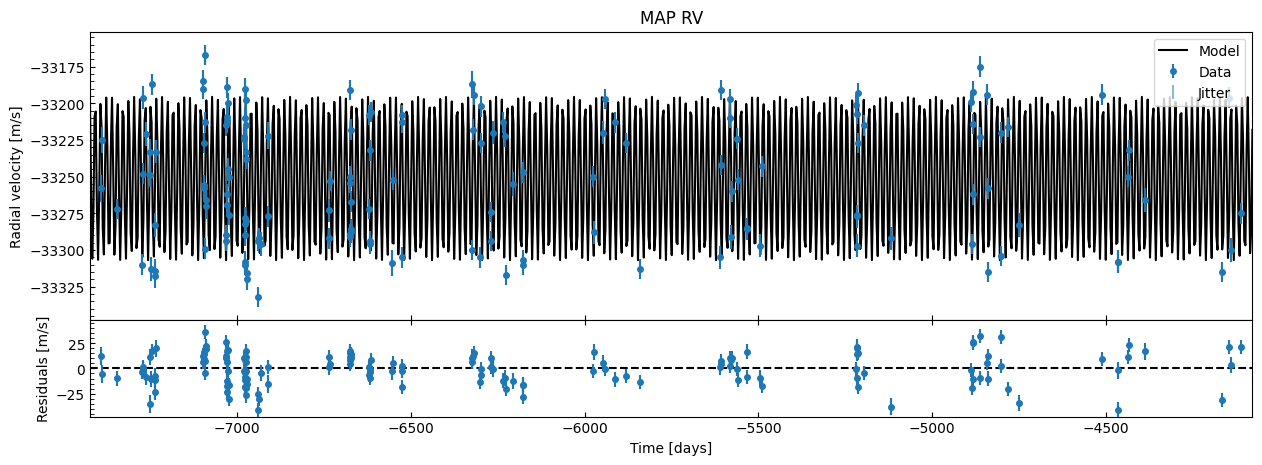

In [ ]:
fitter.plot_MAP_rv(map_result=map_result, save=False)

The residuals look okay, but because of how spread out the data is over time, it's hard to really gauge how well the planet Keplerian model is fitting to the data. So let's create an orbital phase plot: fold the data over the orbital period $P$ around the mid-transit (inferior conjunction) time $T_c$, and show just the RV contribution of the planet (subtracting any system trend).

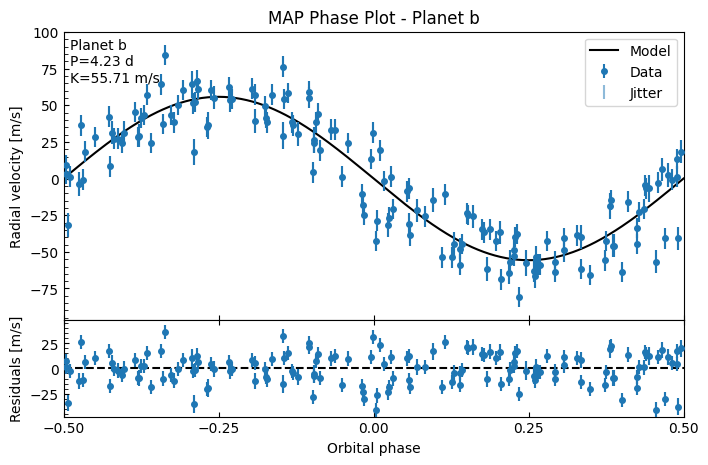

In [ ]:
fitter.plot_MAP_phase(map_result=map_result, planet_letter="b", save=False)

That looks like a reasonable fit!

Next, MCMC is used to explore the parameter space to estimate the parameter uncertainties and fully explore the parameter space. We can initialise the walkers in a small ball around our MAP values using the function `generate_initial_walker_positions_from_map`. They will still spread out and explore the function space. It also ensures each walker starts in a position that both satisfies the boundaries of the prior functions, and that is astrophysically valid (e.g. still satifies $P>0$ or $0\leq{e}<1$.)

There is also a function `generate_initial_walker_positions_random`, that randomly spreads the initial positions within the prior ranges. You can also supply a set of values to `generate_initial_walker_positions_around_point` and it will make a set of values for each walker around the points you provided (like the `...from_map()` version does from the MAP results).

Alternatively, you can supply your own starting values for each walker to the `run_mcmc` command directly, but you need to be careful that they are physically valid and that they satisfy the walkers. It is **strongly recommended** that you fuzz the values in these cases - do not pass identical values for each walker to the MCMC!

In [ ]:
nwalkers = 2 * len(fitter.free_params_dict)  # Minimum number of walkers is 2 * number of free params
mcmc_init = fitter.generate_initial_walker_positions_from_map(map_result=map_result, nwalkers=nwalkers, scale=1e-5)

You'll likely want to run your real MCMC with considerably more steps than this. A small number was chosen here to keep the notebook computation time to a minimum. Furthermore, you'll also want considerably more walkers (at least one hundred!)

In [ ]:
max_steps = 15_000  # You probably want to run for much longer than this!
samples = fitter.run_mcmc(initial_positions=mcmc_init, nwalkers=nwalkers, max_steps=max_steps, progress=True,)  # This will take a while!

INFO:root:Starting MCMC for 15000 steps...
100%|██████████| 15000/15000 [00:03<00:00, 4016.82it/s]
INFO:root:...MCMC done.


Now that the MCMC is finished, the `emcee` sampler has been saved into the `Fitter` object. We can therefore interact with it in the usual way to export the samples, as a numpy array that can be passed into other functions (such as for comparing two models by calculating the Bayesian evidence - example notebook coming soon!). We can also export them into a Pandas dataframe, which keeps each parameter labelled. In both cases, we can pass in the `discard_start` and `thin` arguments as desired.

In [ ]:
# Get the results from the sampler, as a numpy array. Discard the burn-in phase, thin the chains.
nburn = 1_000
thin_rate = 10

samples = fitter.get_samples_np(discard_start=nburn, discard_end=0, thin=thin_rate)
print(samples.shape)  # (nsteps, nwalkers, nparams)

# Get the (flattened) samples as a labelled Pandas dataframe
samples_df = fitter.get_samples_df(discard_start=nburn, discard_end=0, thin=thin_rate)
samples_df  # shape (nsteps*nwalkers, nparams)

(1400, 8, 4)


,P_b,K_b,Tc_b,g
0,4.229999,55.268272,-674.129550,-33251.387591
1,4.230002,56.107437,-674.095335,-33251.065206
2,4.230001,55.653682,-674.109048,-33250.946433
3,4.230001,55.591779,-674.107732,-33251.411678
4,4.230001,55.363514,-674.114039,-33251.366255
...,...,...,...,...
11195,4.230001,56.180308,-674.118166,-33251.289893
11196,4.230000,55.723806,-674.128872,-33251.015685
11197,4.229999,55.519916,-674.117843,-33250.556714
11198,4.230000,54.946946,-674.114655,-33251.767366


To inspect the chains visually, we can plot (and optionally save) the time series of each parameter in the chain. If you want to overplot a value for each parameter (such as the MAP solution or some published values), you can pass a list to the `truths` argument, e.g. `truths=map_result.x`.

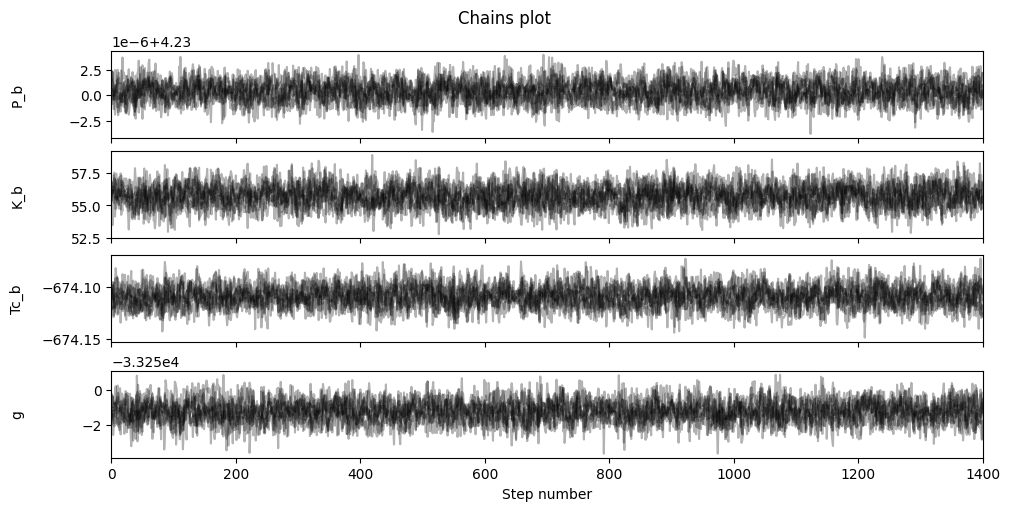

In [ ]:
fitter.plot_chains(discard_start=nburn, discard_end=0, thin=thin_rate, save=False)

These look very well-mixed: you can zoom in on the burn-in period by changing `discard_start` to 0 and `discard_end` argument to instead discard everything *after* the burn-in period, to see that the walkers did initialise converged around the MAP, but quickly started exploring the parameter space around the solution.

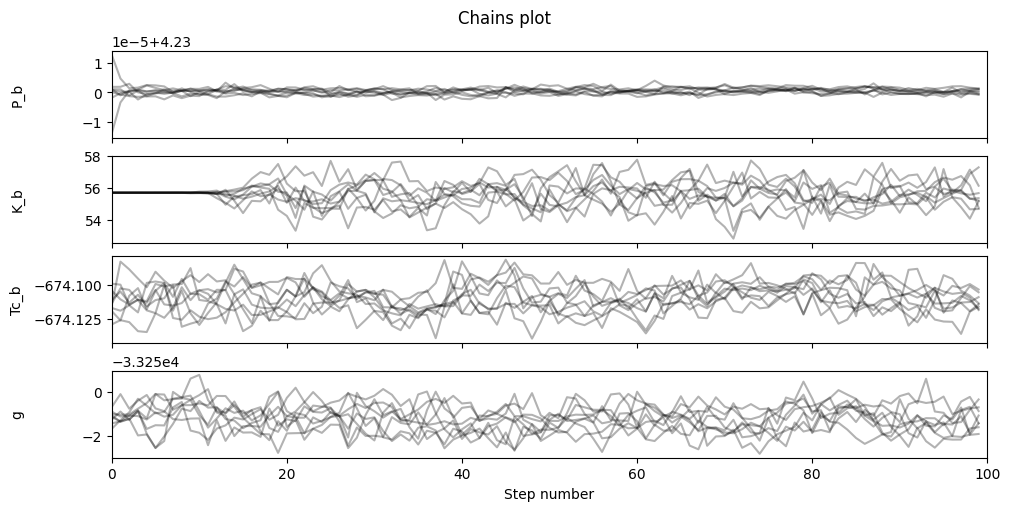

In [ ]:
fitter.plot_chains(discard_start=0, discard_end=max_steps-nburn, thin=thin_rate, save=False)

One quick check we can do is get the parameter values at the sample with the best (highest) log probability. We can compare these to the MAP values, they should be nearly identical - if not, maybe the MAP got stuck in a local maximum?

In [ ]:
best_lnprob_params = fitter.get_sample_with_best_lnprob(discard_start=nburn, discard_end=0, thin=thin_rate)
MAP_params = dict(zip(fitter.free_params_dict.keys(), map_result.x))
print("Best sample param values:", best_lnprob_params)
print(" MAP result param values:", MAP_params)

Best sample found with log probability -794.835923 at index 9660 of samples (with discard_start=1000, discard_end=0, thin=10)
Best sample param values: {'P_b': 4.2300001804489815, 'K_b': 55.58321183884402, 'Tc_b': -674.1098648467887, 'g': -33251.2717784089}
 MAP result param values: {'P_b': 4.230000383665882, 'K_b': 55.7090506156201, 'Tc_b': -674.1092511099605, 'g': -33251.24252246648}


We can also visualise the posterior parameter distributions in corner plots, using the `corner` module. If you want to see how the parameter distributions compared to the MAP solution, pass `truths=map_result.x` as an argument. This can be a useful diagnostic to check the MAP didn't get stuck in a local maximum, or to compare published parameter values to your distributions.

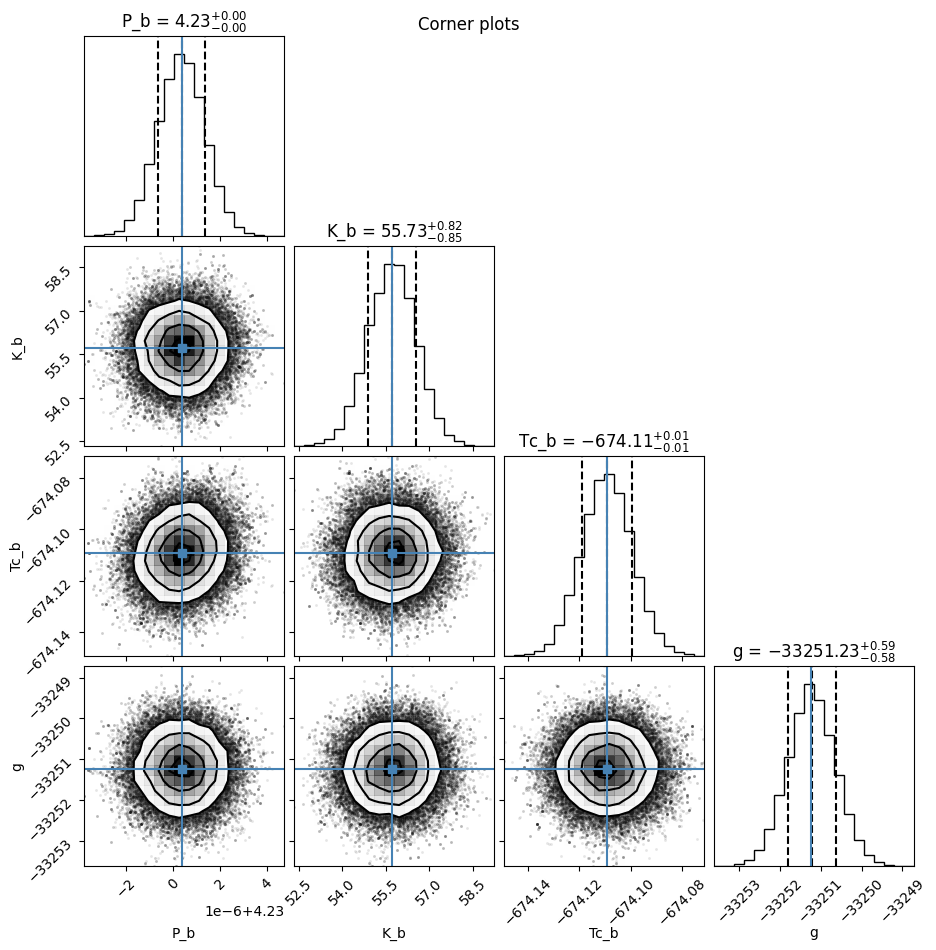

In [ ]:
fitter.plot_corner(discard_start=nburn, truths=map_result.x, plot_datapoints=True, save=False)

In this case, the automatically generated value and error (the 16th, 50th and 84th percentiles) are fairly representative, but you should always inspect the posterior corner plots as distributions won't always be normal/symmetric. For further analysis and inspection, recall we can get a dataframe of the samples with the `Fitter.get_samples_df()` method we saw earlier.

We can also look at the posterior RV to eyeball whether it is a good fit to the data.

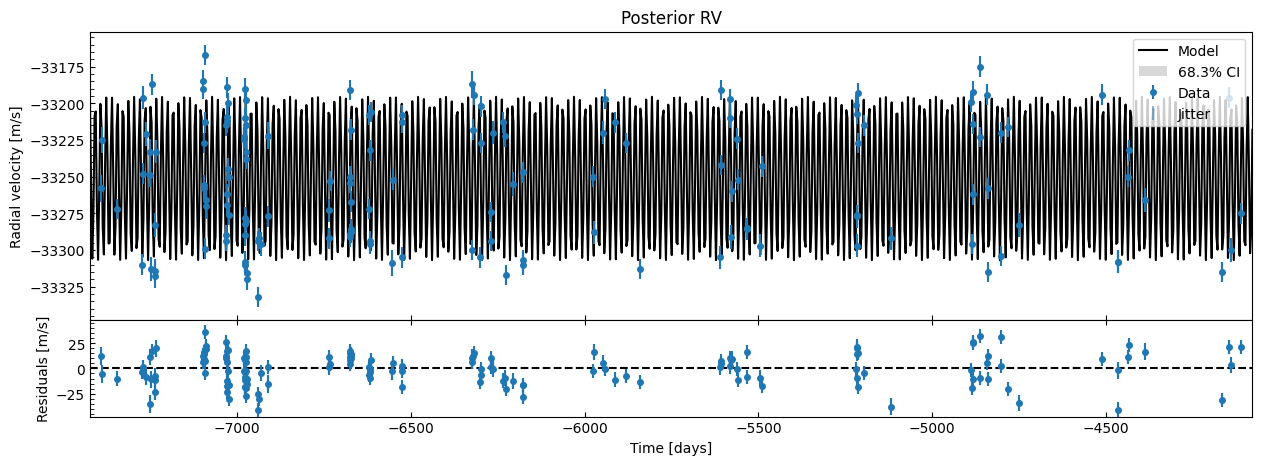

In [ ]:
fitter.plot_posterior_rv(discard_start=nburn, discard_end=0, thin=thin_rate)

Residuals look okay. Let's do an orbital phase plot again to get a better look.

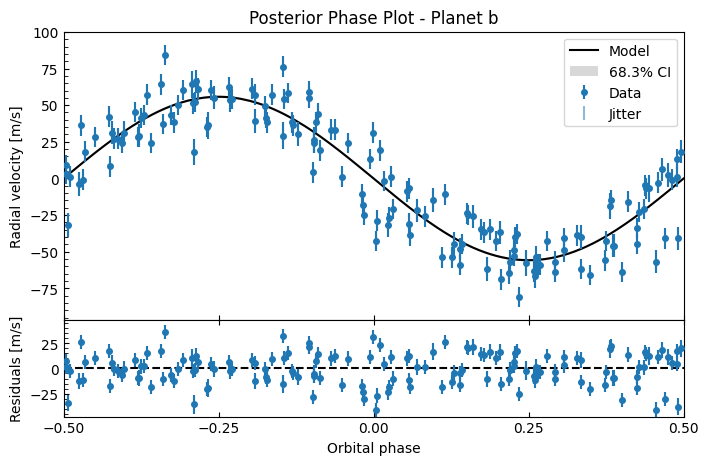

In [ ]:
fitter.plot_posterior_phase("b", discard_start=nburn, discard_end=0, thin=thin_rate)

## Calculate $M_p\sin{i}$
Now that we have fitted for the parameters, we can investigate the $M_p\sin{i}$ of 51 Peg b. To do this, we'll pass in the samples from the `Fitter` for the parameters we need. We also need the stellar mass, which I've again obtained from Birkby et al. 2017. The relationship between planetary mass and RV semi-amplitude is given by

$$ M_p\sin{i}=K\sqrt{1-e^2}\left(\frac{PM^2_*}{2\pi G}\right)^{1/3}. $$

51 peg b Mpsini: 0.47508011837723196 +0.02 -0.02 M_jupiter


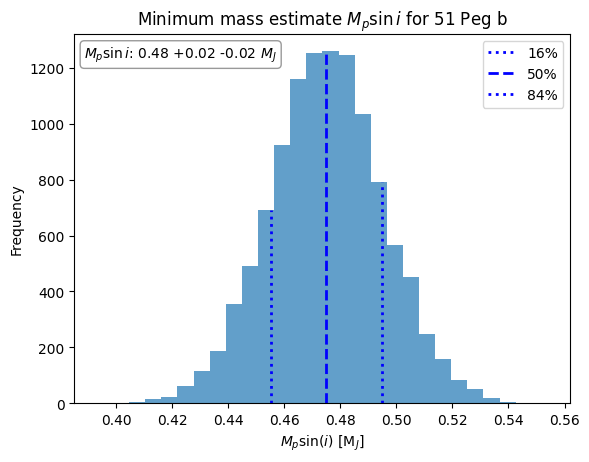

In [ ]:
# Stellar mass values from Birkby et al. 2017
mass_star_val = 1.11  # [M_sun]
mass_star_err = 0.066  # [M_sun]


# Create a distribution to ensure the uncertainty in the stellar mass is captured in the mpsini uncertainty
np.random.seed(47)  # For reproducibility
mass_star = np.random.normal(loc=mass_star_val, scale=mass_star_err, size=len(samples_df))
# Ensure all values in mass_star are positive (incredibly unlikely to be an issue with these values, but just in case)
while any(mass_star <= 0):
    mass_star[mass_star <= 0] = np.random.normal(loc=mass_star_val, scale=mass_star_err, size=sum(mass_star <= 0))

# Get the posterior samples (both free and fixed) as a dictionary
post_samples = fitter.get_mcmc_posterior_dict(discard_start=nburn, thin=thin_rate)

# Calculate the mpsini value - choose whether M_jupiter, M_earth or kg
mpsini = calculate_mpsini(mass_star, post_samples["P_b"], post_samples["K_b"], post_samples["e_b"], unit="M_jupiter")

# Calculate the histogram bin width using Astropy's Knuth bin width
width, edges = knuth_bin_width(mpsini, return_bins=True)

# Let's plot the mpsini posterior distribution in a histogram
fig, ax = plt.subplots(1, 1)
ax.set_title("Minimum mass estimate $M_p\sin{i}$ for 51 Peg b")
ax.set_xlabel("$M_p \sin(i)$ [M$_J$]")
ax.set_ylabel("Frequency")
plot = ax.hist(mpsini, bins=edges, color="tab:blue", alpha=0.7)

# Let's overplot the 16th, 50th and 84th percentiles
ps = np.percentile(mpsini, [16, 50, 84])
# Search for the heights of the bins in which the percentiles are located
heights = plot[0][np.searchsorted(plot[1], ps, side='left')-1]
# The line height will be bin-height / y_bound
_, ymax = ax.get_ybound()
ax.axvline(ps[0], label='16%', color='blue', linestyle=':', linewidth=2, ymax=heights[0] / ymax)
ax.axvline(ps[1], label='50%', color='blue', linestyle='--', linewidth=2, ymax=heights[1] / ymax)
ax.axvline(ps[2], label='84%', color='blue', linestyle=':', linewidth=2, ymax=heights[2] / ymax)

# print the mass to two decimal places with +- uncertaintiees (the 16 84 percentiles) in a box in top left
ax.text(0.02, 0.97, f"$M_{{p}}\sin{{i}}$: {ps[1]:.2f} +{ps[2]-ps[1]:.2f} -{ps[1]-ps[0]:.2f} $M_{{J}}$", transform=ax.transAxes, fontsize=10, va='top', ha='left', bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))
plt.legend(loc="upper right")
print(f"51 peg b Mpsini: {ps[1]:} +{ps[2]-ps[1]:.1g} -{ps[1]-ps[0]:.1g} M_jupiter")